# 01 - ETL: Rotatividade de funcionários (IBM HR)
**Objetivo:** carregar os dados brutos, inspecionar, limpar, transformar e salvar um CSV limpo para uso na EDA e no Power BI.

## Importação de Bibliotecas

In [2]:
import os
import re
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

## Caminhos de Arquivo

In [3]:
# Nomes dos arquivos
nome_entrada = 'WA_Fn-UseC_-HR-Employee-Attrition.csv'
nome_saida   = 'WA_Fn-UseC_-HR-Employee-Attrition_clean.csv'

# Caminhos
caminho_entrada = f'../data/{nome_entrada}'
caminho_saida   = f'../data/{nome_saida}'

print('Arquivo de entrada:', caminho_entrada)
print('Arquivo de saída  :', caminho_saida)

Arquivo de entrada: ../data/WA_Fn-UseC_-HR-Employee-Attrition.csv
Arquivo de saída  : ../data/WA_Fn-UseC_-HR-Employee-Attrition_clean.csv


## Leitura do Arquivo

In [4]:
# Leitura dos dados (com verificação de existência e fallback de encoding)
if not os.path.exists(caminho_entrada):
    raise FileNotFoundError(f"Arquivo não encontrado: {caminho_entrada}. Verifique o caminho e tente novamente.")

try:
    df = pd.read_csv(caminho_entrada, encoding='utf-8')
except UnicodeDecodeError:
    df = pd.read_csv(caminho_entrada, encoding='latin1')

print('Dimensão inicial:', df.shape)
df.head(5)

Dimensão inicial: (1470, 35)


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2


## Padronizar nomes em snake_case

In [5]:
# Padronizar nomes das colunas para snake_case
colunas_originais = df.columns.tolist()

cols = pd.Index(colunas_originais)
cols = (
    cols
    # Quebra fronteira minúscula/dígito -> MAIÚSCULA (AgeGroup -> Age_Group; Var2X -> Var2_X)
    .str.replace(r'([a-z0-9])([A-Z])', r'\1_\2', regex=True)
    # Quebra acrônimo -> Palavra (XMLID -> XML_ID; HRAttrition -> HR_Attrition)
    .str.replace(r'([A-Z]+)([A-Z][a-z])', r'\1_\2', regex=True)
    # Substitui não alfanumérico por _ e normaliza
    .str.replace(r'\W+', '_', regex=True)
    .str.replace(r'_+', '_', regex=True)
    .str.strip('_')
    .str.lower()
)

df.columns = cols

# Conferência rápida
pd.DataFrame({'original': colunas_originais, 'snake_case': df.columns}).head(10)

,original,snake_case
0,Age,age
1,Attrition,attrition
2,BusinessTravel,business_travel
3,DailyRate,daily_rate
4,Department,department
5,DistanceFromHome,distance_from_home
6,Education,education
7,EducationField,education_field
8,EmployeeCount,employee_count
9,EmployeeNumber,employee_number


In [6]:
df.head(5)

,age,attrition,business_travel,daily_rate,department,distance_from_home,education,education_field,employee_count,employee_number,environment_satisfaction,gender,hourly_rate,job_involvement,job_level,job_role,job_satisfaction,marital_status,monthly_income,monthly_rate,num_companies_worked,over18,over_time,percent_salary_hike,performance_rating,relationship_satisfaction,standard_hours,stock_option_level,total_working_years,training_times_last_year,work_life_balance,years_at_company,years_in_current_role,years_since_last_promotion,years_with_curr_manager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2


## Renomear colunas para português

In [7]:
# Renomear colunas para português, mantendo o snake_case.
map_pt = {
    'age': 'idade',
    'business_travel': 'viagem_negocios',
    'daily_rate': 'tarifa_diaria',
    'department': 'departamento',
    'distance_from_home': 'distancia_casa',
    'education': 'educacao',
    'education_field': 'area_educacao',
    'employee_count': 'contagem_empregados',
    'employee_number': 'matricula',
    'environment_satisfaction': 'satisfacao_ambiente',
    'gender': 'genero',
    'hourly_rate': 'tarifa_hora',
    'job_involvement': 'envolvimento_cargo',
    'job_level': 'nivel_cargo',
    'job_role': 'funcao',
    'job_satisfaction': 'satisfacao_cargo',
    'marital_status': 'estado_civil',
    'monthly_income': 'salario_mensal',
    'monthly_rate': 'taxa_mensal',
    'num_companies_worked': 'num_empresas_trabalhou',
    'over18': 'maior_de_idade',
    'over_time': 'horas_extras',
    'percent_salary_hike': 'aumento_salarial_perc',
    'performance_rating': 'nota_desempenho',
    'relationship_satisfaction': 'satisfacao_relacionamento',
    'standard_hours': 'horas_padrao',
    'stock_option_level': 'nivel_opcao_acao',
    'total_working_years': 'anos_totais_trabalho',
    'training_times_last_year': 'treinos_ultimo_ano',
    'work_life_balance': 'equilibrio_vida_trabalho',
    'years_at_company': 'anos_empresa',
    'years_in_current_role': 'anos_cargo_atual',
    'years_since_last_promotion': 'anos_desde_ultima_promocao',
    'years_with_curr_manager': 'anos_com_gestor',
    'attrition': 'desligamento'
}

aplicar_renome_pt = True

if aplicar_renome_pt:
    mapeamento_usado = {k: v for k, v in map_pt.items() if k in df.columns}
    df = df.rename(columns=mapeamento_usado)
    print('Colunas renomeadas para PT (parcial conforme disponibilidade).')

Colunas renomeadas para PT (parcial conforme disponibilidade).


In [8]:
df.head(5)

,idade,desligamento,viagem_negocios,tarifa_diaria,departamento,distancia_casa,educacao,area_educacao,contagem_empregados,matricula,satisfacao_ambiente,genero,tarifa_hora,envolvimento_cargo,nivel_cargo,funcao,satisfacao_cargo,estado_civil,salario_mensal,taxa_mensal,num_empresas_trabalhou,maior_de_idade,horas_extras,aumento_salarial_perc,nota_desempenho,satisfacao_relacionamento,horas_padrao,nivel_opcao_acao,anos_totais_trabalho,treinos_ultimo_ano,equilibrio_vida_trabalho,anos_empresa,anos_cargo_atual,anos_desde_ultima_promocao,anos_com_gestor
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2


## Análise Inicial dos Dados

In [9]:
# Análise inicial: shape, dtypes, amostra
print('Dimensão:', df.shape, '\n')
print('Tipos de dados:')
print(df.dtypes.sort_index())
print('\nAmostra:')
df.head(5)

Dimensão: (1470, 35) 

Tipos de dados:
anos_cargo_atual               int64
anos_com_gestor                int64
anos_desde_ultima_promocao     int64
anos_empresa                   int64
anos_totais_trabalho           int64
area_educacao                 object
aumento_salarial_perc          int64
contagem_empregados            int64
departamento                  object
desligamento                  object
distancia_casa                 int64
educacao                       int64
envolvimento_cargo             int64
equilibrio_vida_trabalho       int64
estado_civil                  object
funcao                        object
genero                        object
horas_extras                  object
horas_padrao                   int64
idade                          int64
maior_de_idade                object
matricula                      int64
nivel_cargo                    int64
nivel_opcao_acao               int64
nota_desempenho                int64
num_empresas_trabalhou         int64

,idade,desligamento,viagem_negocios,tarifa_diaria,departamento,distancia_casa,educacao,area_educacao,contagem_empregados,matricula,satisfacao_ambiente,genero,tarifa_hora,envolvimento_cargo,nivel_cargo,funcao,satisfacao_cargo,estado_civil,salario_mensal,taxa_mensal,num_empresas_trabalhou,maior_de_idade,horas_extras,aumento_salarial_perc,nota_desempenho,satisfacao_relacionamento,horas_padrao,nivel_opcao_acao,anos_totais_trabalho,treinos_ultimo_ano,equilibrio_vida_trabalho,anos_empresa,anos_cargo_atual,anos_desde_ultima_promocao,anos_com_gestor
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2


## Qualidade dos Dados

In [10]:
# Verificações de nulos, duplicados e cardinalidade
nulos = df.isna().sum().sort_values(ascending=False)
print('Nulos por coluna (top 20):')
print(nulos.head(20))

duplicados = df.duplicated().sum()
print('\nRegistros duplicados:', duplicados)

card = df.nunique().sort_values()
baixa_info = card[card <= 1].index.tolist()
print('\nColunas com baixa informação (nunique <= 1)', baixa_info)




Nulos por coluna (top 20):
idade                  0
desligamento           0
viagem_negocios        0
tarifa_diaria          0
departamento           0
distancia_casa         0
educacao               0
area_educacao          0
contagem_empregados    0
matricula              0
satisfacao_ambiente    0
genero                 0
tarifa_hora            0
envolvimento_cargo     0
nivel_cargo            0
funcao                 0
satisfacao_cargo       0
estado_civil           0
salario_mensal         0
taxa_mensal            0
dtype: int64

Registros duplicados: 0

Colunas com baixa informação (nunique <= 1) ['contagem_empregados', 'maior_de_idade', 'horas_padrao']


## Tratando os Dados

In [11]:
# Tratamento de valores ausentes
colunas_num = df.select_dtypes(include='number').columns.tolist()
colunas_cat = df.select_dtypes(exclude='number').columns.tolist()

for c in colunas_num:
    if df[c].isna().any():
        df[c] = df[c].fillna(df[c].median())

for c in colunas_cat:
    if df[c].isna().any():
        df[c] = df[c].fillna['Unkown']

# Ajustes de tipos e flags
if 'desligamento' in df.columns:
    df['saiu'] = df['desligamento'].map({'Yes': True, 'No': False, True: True, False: False})

if 'over_time' in df.columns:
    df['horas_extras_flag'] = df['horas_extras'].map({'Yes': True, 'No': False, True: True, False: False})

if 'nivel_cargo' in df.columns:
    df['gestor_flag'] = (df['nivel_cargo'].astype(float) >= 3)

# Converter colunas em category
candidatos_cat = ['viagem_negocios', 'departamento', 'area_educacao', 'genero', 'funcao',
    'estado_civil', 'horas_extras']
for c in candidatos_cat:
    if c in df.columns:
        df[c] = df[c].astype('category')
        
# Converter colunas em numeric
candidatos_cand = ["salario_mensal", "satisfacao_cargo", "satisfacao_ambiente",
        "satisfacao_relacionamento", "equilibrio_vida_trabalho"]
for c in candidatos_cand:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c].astype(str), errors="coerce")

# Converter em binário
if "desligamento" in df.columns:
    df["saiu"] = df["desligamento"].map({"Yes": 1, "No": 0}).astype("float64")

# Remover colunas de baixa informação (se existirem)
if 'baixa_info' in globals():
    if baixa_info:
        df = df.drop(columns=baixa_info)
        print('Removidas colunas de baixa informação:', baixa_info)

print('Após tratamentos -> shape:', df.shape)

df.head(5)

Removidas colunas de baixa informação: ['contagem_empregados', 'maior_de_idade', 'horas_padrao']
Após tratamentos -> shape: (1470, 34)


,idade,desligamento,viagem_negocios,tarifa_diaria,departamento,distancia_casa,educacao,area_educacao,matricula,satisfacao_ambiente,genero,tarifa_hora,envolvimento_cargo,nivel_cargo,funcao,satisfacao_cargo,estado_civil,salario_mensal,taxa_mensal,num_empresas_trabalhou,horas_extras,aumento_salarial_perc,nota_desempenho,satisfacao_relacionamento,nivel_opcao_acao,anos_totais_trabalho,treinos_ultimo_ano,equilibrio_vida_trabalho,anos_empresa,anos_cargo_atual,anos_desde_ultima_promocao,anos_com_gestor,saiu,gestor_flag
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Yes,11,3,1,0,8,0,1,6,4,0,5,1.0,False
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,No,23,4,4,1,10,3,3,10,7,1,7,0.0,False
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Yes,15,3,2,0,7,3,3,0,0,0,0,1.0,False
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Yes,11,3,3,0,8,3,3,8,7,3,0,0.0,False
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,No,12,3,4,1,6,3,3,2,2,2,2,0.0,False


## Detecção e Tratamento de Outliers

In [12]:
# Outliers: análise (IQR) em colunas numéricas
col_num = df.select_dtypes(include='number').columns.tolist()
resumo_outliers = []
limites_iqr = {}

for c in col_num:
    serie = df[c].dropna()
    if serie.empty:
        continue
    q1 = serie.quantile(0.25)
    q3 = serie.quantile(0.75)
    iqr = q3 - q1
    li = q1 - 1.5 * iqr
    ls = q3 + 1.5 * iqr
    limites_iqr[c] = (li, ls)
    mask = (df[c] < li) | (df[c] > ls)
    resumo_outliers.append({'coluna': c, 'li': li, 'ls': ls, 'n_outliers': int(mask.sum()), 'pct': float(100*mask.mean())})

resumo_outliers = pd.DataFrame(resumo_outliers).sort_values('pct', ascending=False)
print('Resumo de outliers (top 15):')
resumo_outliers.head(15)

Resumo de outliers (top 15):


,coluna,li,ls,n_outliers,pct
18,treinos_ultimo_ano,0.5,4.5,238,16.190476
24,saiu,0.0,0.0,237,16.122449
14,nota_desempenho,3.0,3.0,226,15.374150
10,salario_mensal,-5291.0,16581.0,114,7.755102
22,anos_desde_ultima_promocao,-4.5,7.5,107,7.278912
20,anos_empresa,-6.0,18.0,104,7.074830
16,nivel_opcao_acao,-1.5,2.5,85,5.782313
17,anos_totais_trabalho,-7.5,28.5,63,4.285714
12,num_empresas_trabalhou,-3.5,8.5,52,3.537415
21,anos_cargo_atual,-5.5,14.5,21,1.428571


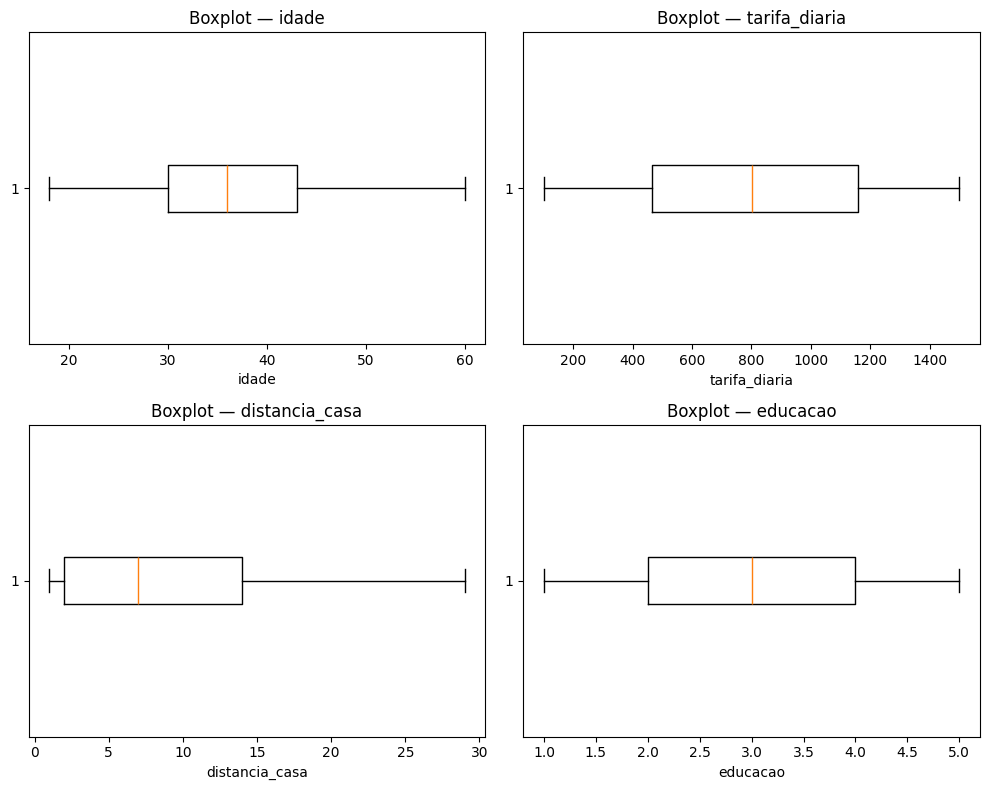

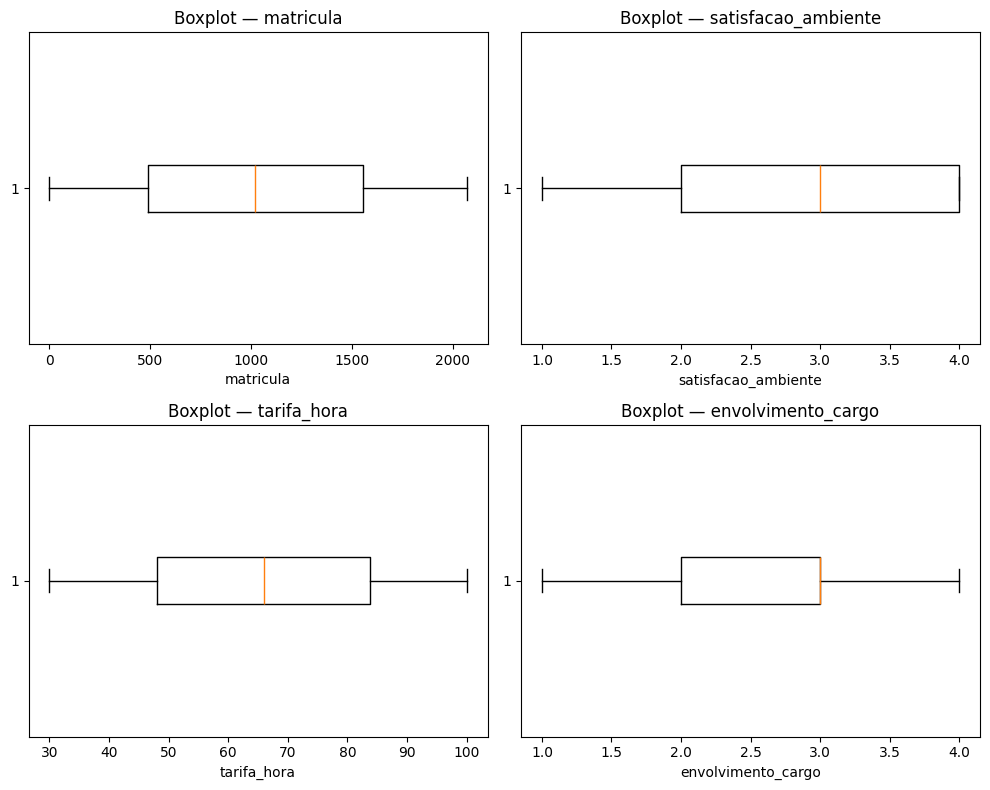

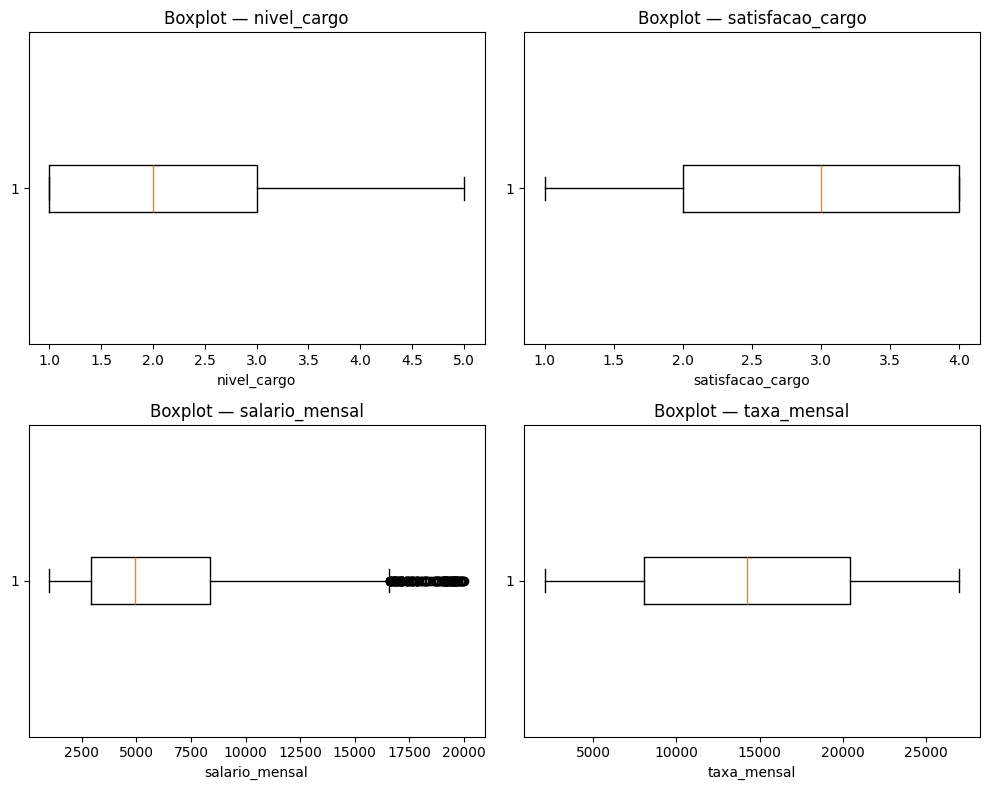

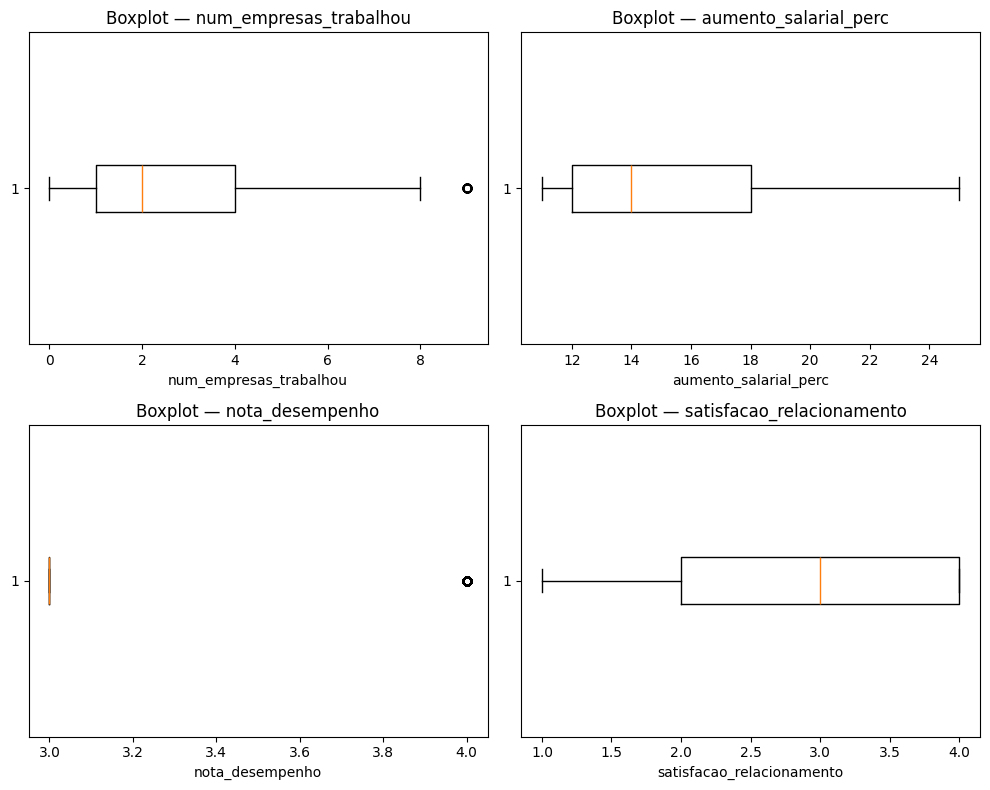

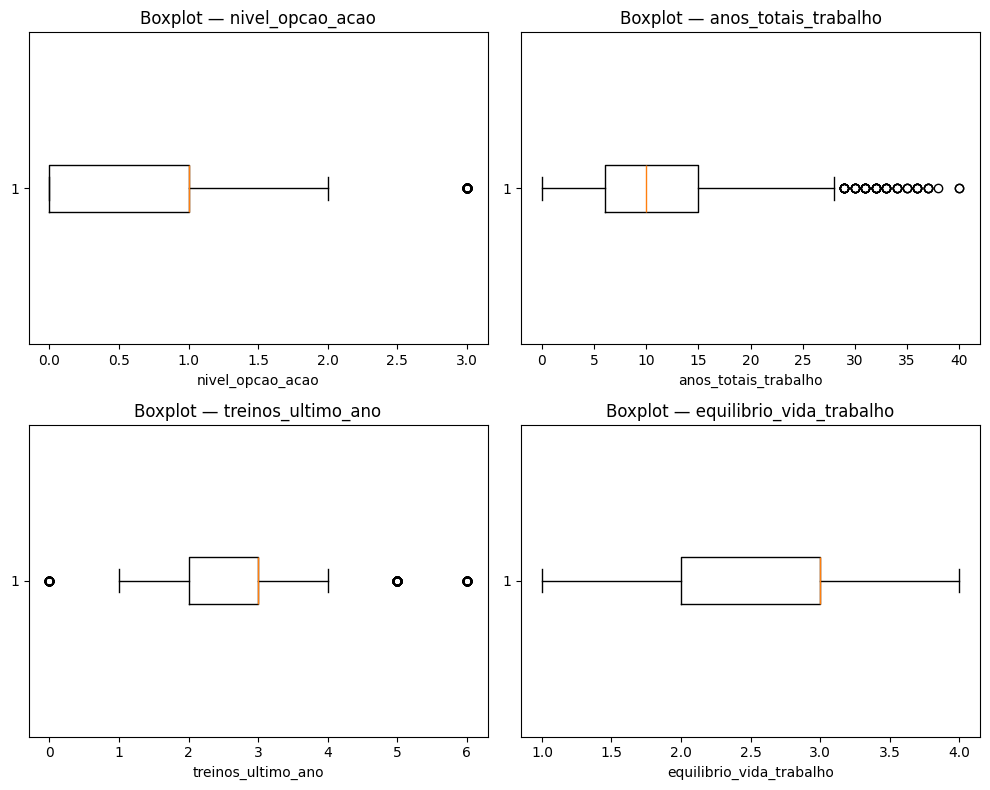

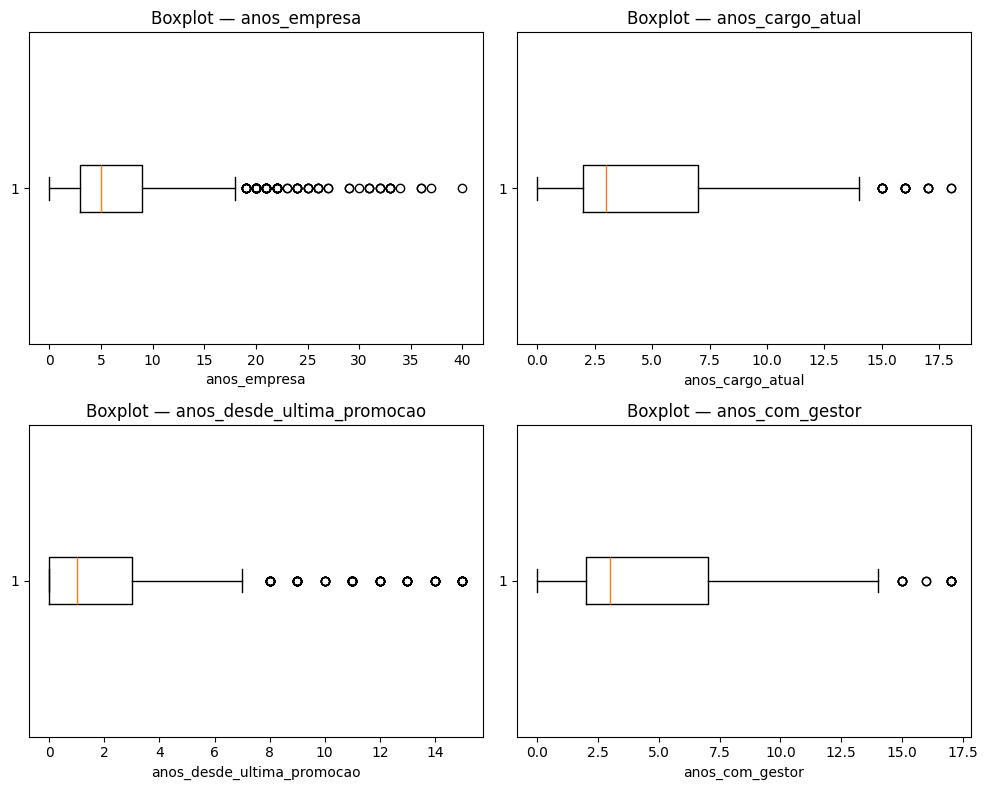

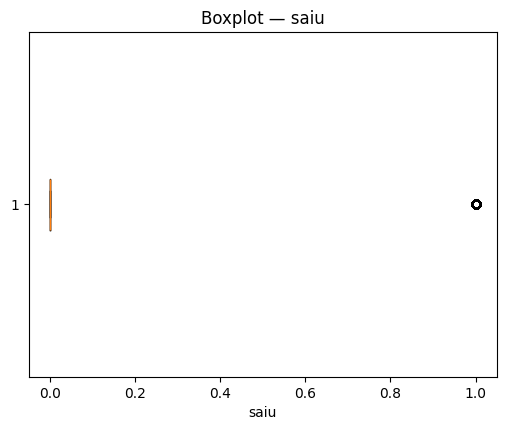

In [13]:
# Boxplots em páginas de 4 gráficos (2x2)
num_cols = df.select_dtypes(include='number').columns.tolist()

for i in range(0, len(num_cols), 4):
    subset = num_cols[i:i+4]
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    axes = axes.flatten()
    
    for j, c in enumerate(subset):
        axes[j].boxplot(df[c].dropna(), vert=False)
        axes[j].set_title(f'Boxplot — {c}')
        axes[j].set_xlabel(c)
    
    # esconde eixos vazios se não tiver 4 colunas
    for k in range(len(subset), 4):
        fig.delaxes(axes[k])
    
    plt.tight_layout()
    plt.show()


In [14]:
# Tratamento de outliers — winsorização por IQR
aplicar_tratamento_outliers = False  # altere para True para aplicar
df_trat = df.copy()
if aplicar_tratamento_outliers:
    for c, (li, ls) in limites_iqr.items():
        if c in df_trat.columns:
            df_trat[c] = df_trat[c].clip(lower=li, upper=ls)
    print('Winsorização aplicada.')
else:
    print('Sem tratamento de outliers.')

Sem tratamento de outliers.


## Cria novas colunas derivadas úteis

In [15]:
df_feat = df_trat

# Faixas de idade
if 'idade' in df_feat.columns:
    df_feat['faixa_idade'] = pd.cut(df_feat['idade'], bins=[0,25,35,45,60,120],
                                    labels=['<=25','26-35','36-45','46-60','60+'], include_lowest=True)

# Faixas de tempo de empresa
if 'anos_empresa' in df_feat.columns:
    df_feat['faixa_tempo_empresa'] = pd.cut(df_feat['anos_empresa'], bins=[-1,1,3,5,10,50],
                                            labels=['<=1','2-3','4-5','6-10','10+'])

# Quartis de salario
if 'salario_mensal' in df_feat.columns:
    try:
        df_feat['faixa_salario'] = pd.qcut(df_feat['salario_mensal'], q=4, labels=["Low Income", "Lower-Middle Income", "sUpper-Middle Income", "High Income"])
    except ValueError:
        df_feat['faixa_salario'] = pd.qcut(df_feat['salario_mensal'].rank(method='first'), q=4, labels=['Q1','Q2','Q3','Q4'])

# Flags
if 'nivel_cargo' in df_feat.columns:
    df_feat['gestor_flag'] = (df_feat['nivel_cargo'].astype(float) >= 3)
if 'horas_extras' in df_feat.columns and 'horas_extras_flag' not in df_feat.columns:
    df_feat['horas_extras_flag'] = df_feat['horas_extras'].map({'Yes': True, 'No': False, True: True, False: False})

# Gap de experiência
if 'anos_totais_trabalho' in df_feat.columns and 'anos_empresa' in df_feat.columns:
    df_feat['gap_experiencia'] = (df_feat['anos_totais_trabalho'] - df_feat['anos_empresa']).clip(lower=0)

# Promoção recente (<= 1 ano)
if 'anos_desde_ultima_promocao' in df_feat.columns:
    df_feat['promocao_recente_flag'] = (df_feat['anos_desde_ultima_promocao'].astype(float) <= 1)

print('Novas colunas (se existirem):', [c for c in ['faixa_idade','faixa_tempo_empresa','salario_quartil','gestor_flag','horas_extras_flag','gap_experiencia','promocao_recente_flag'] if c in df_feat.columns])
df_feat.head(5)

Novas colunas (se existirem): ['faixa_idade', 'faixa_tempo_empresa', 'gestor_flag', 'horas_extras_flag', 'gap_experiencia', 'promocao_recente_flag']


,idade,desligamento,viagem_negocios,tarifa_diaria,departamento,distancia_casa,educacao,area_educacao,matricula,satisfacao_ambiente,genero,tarifa_hora,envolvimento_cargo,nivel_cargo,funcao,satisfacao_cargo,estado_civil,salario_mensal,taxa_mensal,num_empresas_trabalhou,horas_extras,aumento_salarial_perc,nota_desempenho,satisfacao_relacionamento,nivel_opcao_acao,anos_totais_trabalho,treinos_ultimo_ano,equilibrio_vida_trabalho,anos_empresa,anos_cargo_atual,anos_desde_ultima_promocao,anos_com_gestor,saiu,gestor_flag,faixa_idade,faixa_tempo_empresa,faixa_salario,horas_extras_flag,gap_experiencia,promocao_recente_flag
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Yes,11,3,1,0,8,0,1,6,4,0,5,1.0,False,36-45,6-10,sUpper-Middle Income,True,2,True
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,No,23,4,4,1,10,3,3,10,7,1,7,0.0,False,46-60,6-10,sUpper-Middle Income,False,0,True
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Yes,15,3,2,0,7,3,3,0,0,0,0,1.0,False,36-45,<=1,Low Income,True,7,True
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Yes,11,3,3,0,8,3,3,8,7,3,0,0.0,False,26-35,6-10,Low Income,True,0,False
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,No,12,3,4,1,6,3,3,2,2,2,2,0.0,False,26-35,2-3,Lower-Middle Income,False,4,False


## Validações finais

In [16]:
df_final = df_feat  # este será o dataset final para exportação

print('Shape final:', df_final.shape)
print('\nNulos (top 20):')
print(df_final.isna().sum().sort_values(ascending=False).head(20))

print('\nDuplicados:', df_final.duplicated().sum())

print('\nTipos de dados:')
print(df_final.dtypes.sort_index())

# Amostra final
df_final.head(5)

Shape final: (1470, 40)

Nulos (top 20):
idade                     0
desligamento              0
viagem_negocios           0
tarifa_diaria             0
departamento              0
distancia_casa            0
educacao                  0
area_educacao             0
matricula                 0
satisfacao_ambiente       0
genero                    0
tarifa_hora               0
envolvimento_cargo        0
nivel_cargo               0
funcao                    0
satisfacao_cargo          0
estado_civil              0
salario_mensal            0
taxa_mensal               0
num_empresas_trabalhou    0
dtype: int64

Duplicados: 0

Tipos de dados:
anos_cargo_atual                 int64
anos_com_gestor                  int64
anos_desde_ultima_promocao       int64
anos_empresa                     int64
anos_totais_trabalho             int64
area_educacao                 category
aumento_salarial_perc            int64
departamento                  category
desligamento                    object
dis

,idade,desligamento,viagem_negocios,tarifa_diaria,departamento,distancia_casa,educacao,area_educacao,matricula,satisfacao_ambiente,genero,tarifa_hora,envolvimento_cargo,nivel_cargo,funcao,satisfacao_cargo,estado_civil,salario_mensal,taxa_mensal,num_empresas_trabalhou,horas_extras,aumento_salarial_perc,nota_desempenho,satisfacao_relacionamento,nivel_opcao_acao,anos_totais_trabalho,treinos_ultimo_ano,equilibrio_vida_trabalho,anos_empresa,anos_cargo_atual,anos_desde_ultima_promocao,anos_com_gestor,saiu,gestor_flag,faixa_idade,faixa_tempo_empresa,faixa_salario,horas_extras_flag,gap_experiencia,promocao_recente_flag
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Yes,11,3,1,0,8,0,1,6,4,0,5,1.0,False,36-45,6-10,sUpper-Middle Income,True,2,True
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,No,23,4,4,1,10,3,3,10,7,1,7,0.0,False,46-60,6-10,sUpper-Middle Income,False,0,True
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Yes,15,3,2,0,7,3,3,0,0,0,0,1.0,False,36-45,<=1,Low Income,True,7,True
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Yes,11,3,3,0,8,3,3,8,7,3,0,0.0,False,26-35,6-10,Low Income,True,0,False
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,No,12,3,4,1,6,3,3,2,2,2,2,0.0,False,26-35,2-3,Lower-Middle Income,False,4,False


## Correlações (numéricas)

In [17]:
# Correlações entre variáveis numéricas
df_final = df_feat
num_cols = df_final.select_dtypes(include='number').columns.tolist()
if num_cols:
    corr = df_final[num_cols].corr(numeric_only=True)
    
    if 'saiu' in df_final.columns:
        rank = corr['saiu'].drop(labels=['saiu'], errors='ignore').abs().sort_values(ascending=False)
        print('Top 15 correlações com desligamento (saiu):')
        print(rank.head(15))
else:
    print('Não há colunas numéricas suficientes.')

df_final.head(5)

Top 15 correlações com desligamento (saiu):
anos_totais_trabalho        0.171063
nivel_cargo                 0.169105
anos_cargo_atual            0.160545
salario_mensal              0.159840
idade                       0.159205
anos_com_gestor             0.156199
nivel_opcao_acao            0.137145
anos_empresa                0.134392
envolvimento_cargo          0.130016
satisfacao_cargo            0.103481
satisfacao_ambiente         0.103369
gap_experiencia             0.082147
distancia_casa              0.077924
equilibrio_vida_trabalho    0.063939
treinos_ultimo_ano          0.059478
Name: saiu, dtype: float64


,idade,desligamento,viagem_negocios,tarifa_diaria,departamento,distancia_casa,educacao,area_educacao,matricula,satisfacao_ambiente,genero,tarifa_hora,envolvimento_cargo,nivel_cargo,funcao,satisfacao_cargo,estado_civil,salario_mensal,taxa_mensal,num_empresas_trabalhou,horas_extras,aumento_salarial_perc,nota_desempenho,satisfacao_relacionamento,nivel_opcao_acao,anos_totais_trabalho,treinos_ultimo_ano,equilibrio_vida_trabalho,anos_empresa,anos_cargo_atual,anos_desde_ultima_promocao,anos_com_gestor,saiu,gestor_flag,faixa_idade,faixa_tempo_empresa,faixa_salario,horas_extras_flag,gap_experiencia,promocao_recente_flag
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Yes,11,3,1,0,8,0,1,6,4,0,5,1.0,False,36-45,6-10,sUpper-Middle Income,True,2,True
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,No,23,4,4,1,10,3,3,10,7,1,7,0.0,False,46-60,6-10,sUpper-Middle Income,False,0,True
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Yes,15,3,2,0,7,3,3,0,0,0,0,1.0,False,36-45,<=1,Low Income,True,7,True
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Yes,11,3,3,0,8,3,3,8,7,3,0,0.0,False,26-35,6-10,Low Income,True,0,False
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,No,12,3,4,1,6,3,3,2,2,2,2,0.0,False,26-35,2-3,Lower-Middle Income,False,4,False


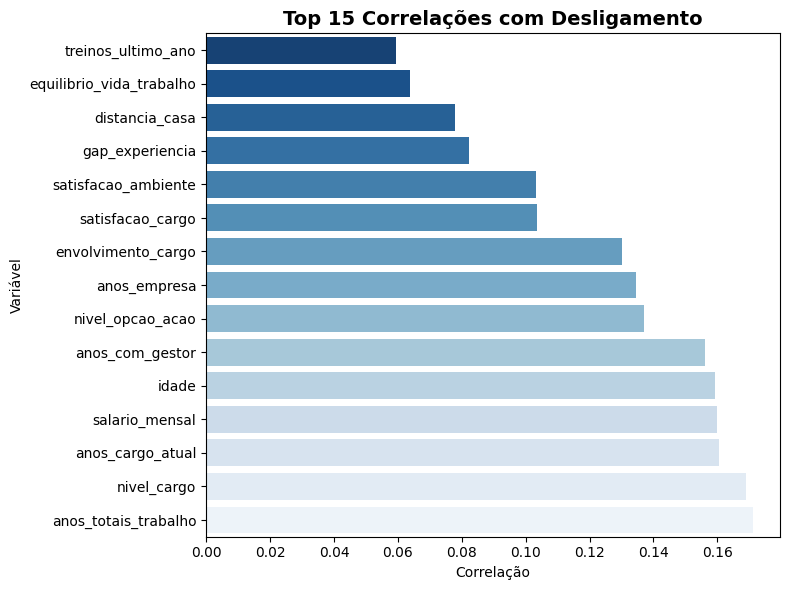

In [18]:
# Gráfico com os Top 15
top_corr = rank.head(15)

df_corr = top_corr.reset_index()
df_corr.columns = ['Variável', 'Correlação']
df_corr = df_corr.sort_values('Correlação', ascending=True)

plt.figure(figsize=(8,6))
sns.barplot(x='Correlação', y='Variável', data=df_corr, palette='Blues_r')
plt.title("Top 15 Correlações com Desligamento", fontsize=14, weight='bold')
plt.xlabel("Correlação")
plt.ylabel("Variável")
plt.tight_layout()
plt.show()

### Interpretação das correlações com `saiu`

Os valores de correlação são baixos (máx. ≈ 0.17), mostrando que **nenhuma variável isolada explica bem a rotatividade**. Ainda assim, surgem alguns indícios:

- **Tempo de trabalho/cargo/empresa** (anos_totais_trabalho, anos_cargo_atual, anos_empresa, anos_com_gestor) têm leve associação positiva com saída — possivelmente por falta de promoção ou estagnação.  
- **Nível do cargo e renda** mostram correlação fraca, indicando que perfis mais altos e com maior salário também podem sair.  
- **Satisfação e envolvimento** (satisfacao_cargo, satisfacao_ambiente, envolvimento_cargo) apresentam relação negativa fraca, sugerindo que menor satisfação aumenta saída.  
- **Distância de casa e gap de experiência** aparecem com efeito pequeno.  
- Variáveis como **treinos_ultimo_ano** e **tarifa_diaria** têm impacto quase irrelevante.

**Conclusão:** a rotatividade é multifatorial; esses padrões servem mais como **indícios de investigação** do que como variáveis preditoras fortes sozinhas.


## Distribuições básicas (histogramas)

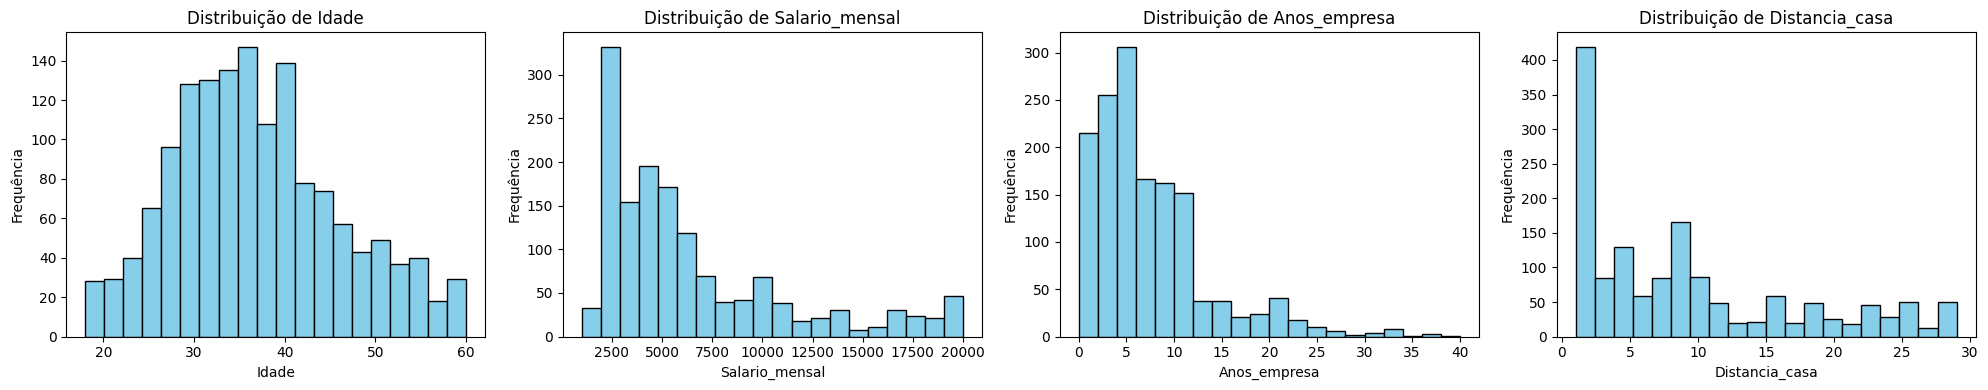

In [19]:
# Distribuições básicas

cols = ['idade','salario_mensal','anos_empresa','distancia_casa']
cols = [c for c in cols if c in df_final.columns]  

fig, axes = plt.subplots(1, len(cols), figsize=(5*len(cols), 4))

if len(cols) == 1:
    axes = [axes]

for ax, c in zip(axes, cols):
    ax.hist(df_final[c].dropna(), bins=20, color='skyblue', edgecolor='black')
    ax.set_title(f'Distribuição de {c.capitalize()}')
    ax.set_xlabel(c.capitalize())
    ax.set_ylabel('Frequência')

plt.tight_layout()
plt.show()

**Interpretação dos histogramas**  
**Idade** – a distribuição é aproximadamente simétrica entre 20 e 60 anos, com maior concentração entre 30 e 40 anos. Mostra uma força de trabalho predominantemente adulta, em idade de consolidação profissional.

**Renda mensal** – fortemente concentrada nas faixas mais baixas (até cerca de R$ 5.000), com uma cauda longa em direção a salários altos. A maioria dos colaboradores ganha pouco, e poucos têm rendas muito elevadas.

**Anos de empresa** – concentração marcante nos primeiros anos (até 5 anos), com quedas progressivas depois disso. Isso sugere que muitos funcionários são relativamente novos na organização.

**Distância de casa** – fortemente concentrada em distâncias curtas (1–5 km), mas com casos espalhados até quase 30 km. A maioria mora perto do trabalho, mas há uma minoria com deslocamentos longos.

**Resumo geral:** os colaboradores são majoritariamente adultos de 30 a 40 anos, com baixa renda mensal, pouco tempo de empresa e morando perto do trabalho. Esses perfis ajudam a entender o contexto da força de trabalho e podem orientar análises sobre retenção e rotatividade.


## Exportar o dataset limpo

In [20]:
# Exportar dataset final
os.makedirs('data', exist_ok=True)
df_final.to_csv(caminho_saida, index=False, encoding='utf-8')
print(f'Exportado: {caminho_saida}  |  shape: {df_final.shape}')

Exportado: ../data/WA_Fn-UseC_-HR-Employee-Attrition_clean.csv  |  shape: (1470, 40)


# 02 - EDA: Rotatividade de Funcionários (IBM HR)
**Objetivo:** explorar os dados limpos, responder perguntas de negócio.

## KPIs principais e perguntas de negócio
- Taxa de rotatividade (geral e por grupos).
- Departamentos e cargos com maior saída.
- Perfil dos desligados (faixa etária, tempo de casa, overtime, faixa salarial).
- Relações entre tempo de empresa, salário e rotatividade.
- Efeito de salário e satisfação sobre a saída.
- Estimativa de custo da rotatividade.

In [21]:
# 1) Taxa de rotatividade (geral)
if "saiu" in df.columns:
    rate = df["saiu"].mean()
    total = len(df)
    qtd = int(df["saiu"].sum())
    print(f"Taxa de rotatividade (geral): {rate:.2%}  |  Desligados: {qtd}/{total}")
else:
    print("Coluna 'saiu' não encontrada.")


Taxa de rotatividade (geral): 16.12%  |  Desligados: 237/1470


,taxa_rotatividade
departamento,
Sales,0.206278
Human Resources,0.190476
Research & Development,0.138398


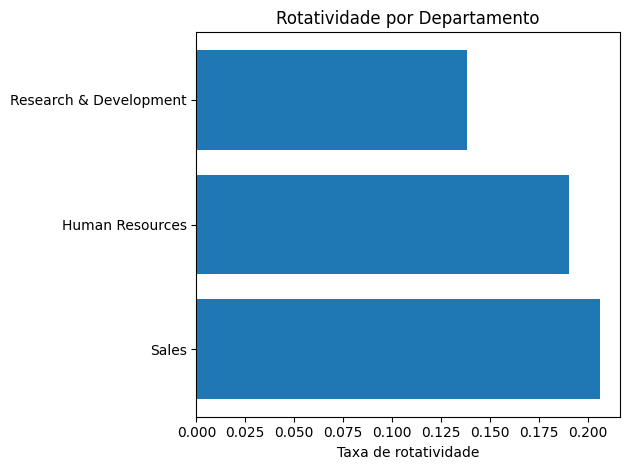

In [22]:
# 2) Rotatividade por departamento
if {"departamento", "saiu"}.issubset(df.columns):
    dept_rate = df.groupby("departamento")["saiu"].mean().sort_values(ascending=False)
    display(dept_rate.to_frame("taxa_rotatividade"))
    
    plt.figure()
    y = np.arange(len(dept_rate))
    plt.barh(y, dept_rate.values)
    plt.yticks(y, dept_rate.index)
    plt.xlabel("Taxa de rotatividade")
    plt.title("Rotatividade por Departamento")
    plt.tight_layout()
    plt.show()
else:
    print("Colunas necessárias não encontradas: 'department', 'attrition_flag'.")

Taxa de rotatividade por faixa_idade:


,taxa_rotatividade
faixa_idade,
<=25,0.357724
26-35,0.191419
46-60,0.124542
36-45,0.091880
60+,NaN


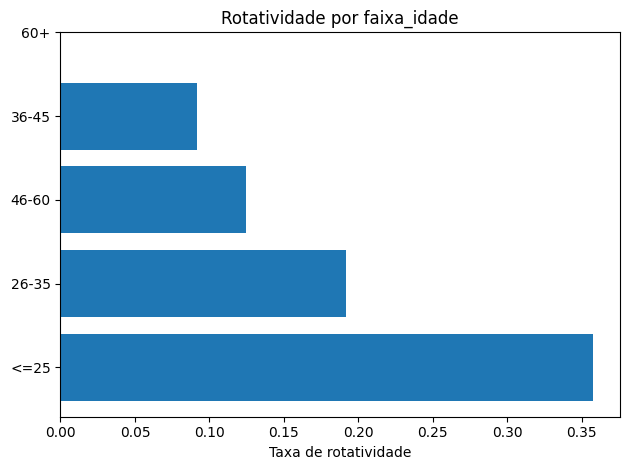

Taxa de rotatividade por faixa_tempo_empresa:


,taxa_rotatividade
faixa_tempo_empresa,
<=1,0.348837
2-3,0.184314
4-5,0.130719
6-10,0.122768
10+,0.081301


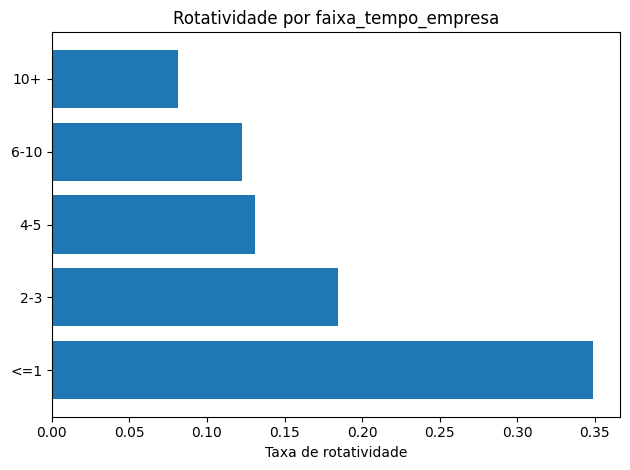

Taxa de rotatividade por horas_extras_flag:


,taxa_rotatividade
horas_extras_flag,
True,0.305288
False,0.104364


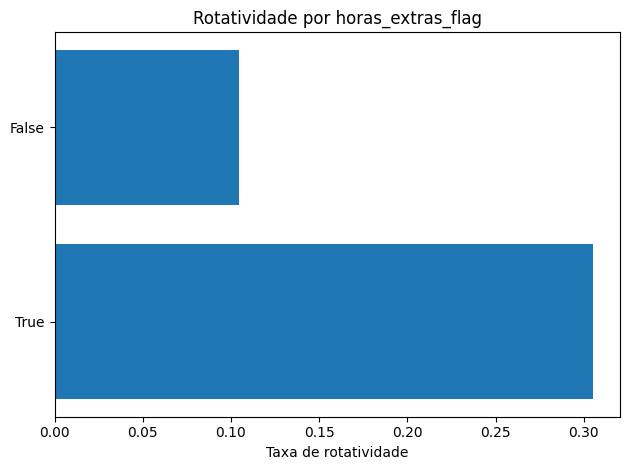

In [23]:
# 3) Perfil dos desligados (faixa etária, tempo de casa, horas extras, faixa salarial)
if "faixa_idade" not in df.columns and "idade" in df.columns:
    df["faixa_idade"] = pd.cut(df["idade"], bins=[0,25,35,45,60,120],
                               labels=["<=25","26-35","36-45","46-60","60+"], include_lowest=True)
if "faixa_tempo_empresa" not in df.columns and "anos_empresa" in df.columns:
    df["faixa_tempo_empresa"] = pd.cut(df["anos_empresa"], bins=[-1,1,3,5,10,50],
                                       labels=["<=1","2-3","4-5","6-10","10+"])
if "faixa_renda" not in df.columns and "renda_mensal" in df.columns:
    try:
         df["faixa_renda"] = pd.qcut(df["renda_mensal"], q=4, labels=["Renda Baixa", "Renda Médio-Baixa", "Renda Médio-Alta", "Renda Alta"])
    except ValueError:
         df["faixa_renda"] = pd.qcut(df["renda_mensal"].rank(method="first"), q=4, labels=["Renda Baixa", "Renda Médio-Baixa", "Renda Médio-Alta", "Renda Alta"])
if "horas_extras_flag" not in df.columns and "horas_extras" in df.columns:
     df["horas_extras_flag"] = df["horas_extras"].map({"Yes": True, "No": False, True: True, False: False})

for col in ["faixa_idade","faixa_tempo_empresa","horas_extras_flag","faixa_renda"]:
    if col in df.columns:
        tab = df.groupby(col)["saiu"].mean().sort_values(ascending=False)
        print(f"Taxa de rotatividade por {col}:")
        display(tab.to_frame("taxa_rotatividade"))
     
        plt.figure()
        if tab.index.dtype.kind in {"O","b","u","i"}:
            y = np.arange(len(tab))
            plt.barh(y, tab.values)
            plt.yticks(y, tab.index.astype(str))
        else:
            plt.bar(range(len(tab)), tab.values)
            plt.xticks(range(len(tab)), tab.index.astype(str), rotation=45)
        plt.xlabel("Taxa de rotatividade")
        plt.title(f"Rotatividade por {col}")
        plt.tight_layout()
        plt.show()

In [24]:
# 4) Relações: tempo de empresa x salário x rotatividade
cols_needed = {"anos_empresa", "renda_mensal", "saiu"}
if cols_needed.issubset(df.columns):
    r_tenure, p_tenure = stats.pointbiserialr(df["saiu"].astype(int), df["anos_empresa"])
    r_income, p_income = stats.pointbiserialr(df["saiu"].astype(int), df["renda_mensal"])
    print(f"r_pb(desligamento, anos_empresa) = {r_tenure:.3f} (p={p_tenure:.3g})")
    print(f"r_pb(desligamento, renda_mensal)   = {r_income:.3f} (p={p_income:.3g})")
    
    sample = df.sample(min(300, len(df)), random_state=42)
    plt.figure()
    plt.scatter(sample["anos_empresa"], sample["renda_mensal"], alpha=0.6)
    plt.xlabel("anos_empresa")
    plt.ylabel("renda_mensal")
    plt.title("Relação: tempo de empresa x renda mensal (amostra)")
    plt.tight_layout()
    plt.show()
else:
    print("Colunas necessárias não encontradas para esta análise.")

Colunas necessárias não encontradas para esta análise.


salario_mensal — média por status (False=ficou, True=saiu):
saiu
0.0    6832.739659
1.0    4787.092827
Name: salario_mensal, dtype: float64


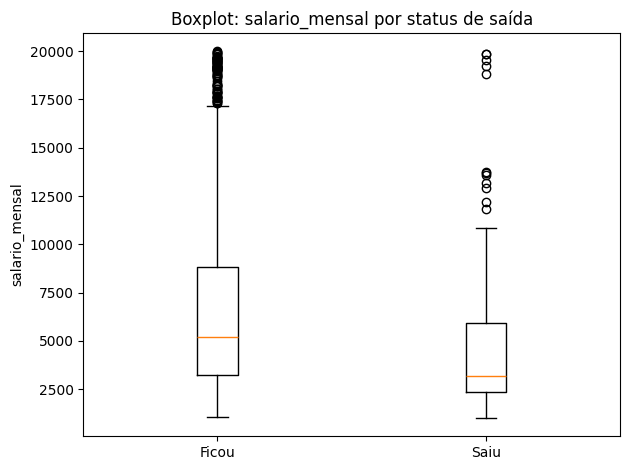

satisfacao_cargo — média por status (False=ficou, True=saiu):
saiu
0.0    2.778589
1.0    2.468354
Name: satisfacao_cargo, dtype: float64


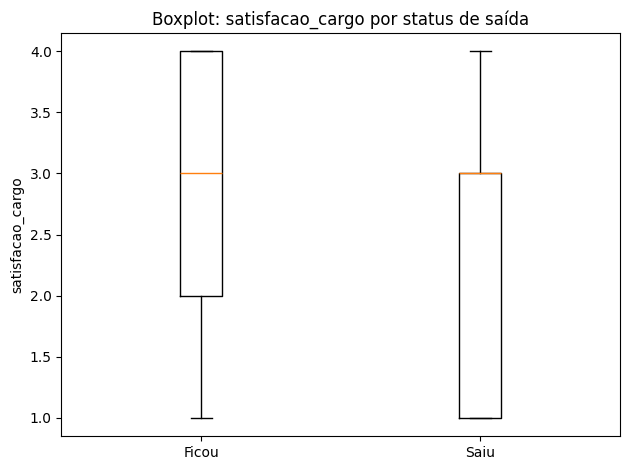

satisfacao_ambiente — média por status (False=ficou, True=saiu):
saiu
0.0    2.771290
1.0    2.464135
Name: satisfacao_ambiente, dtype: float64


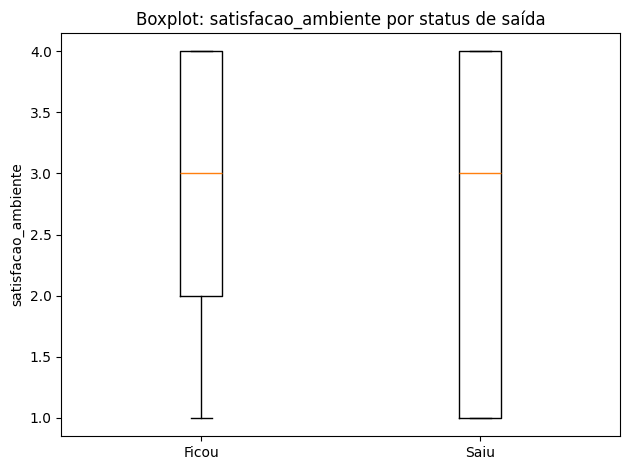

satisfacao_relacionamento — média por status (False=ficou, True=saiu):
saiu
0.0    2.733982
1.0    2.599156
Name: satisfacao_relacionamento, dtype: float64


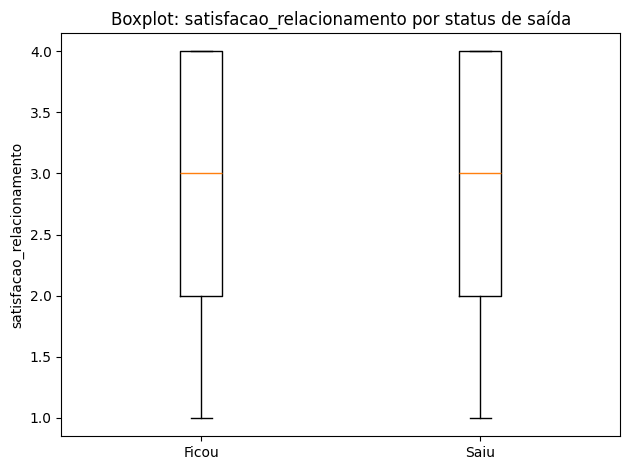

equilibrio_vida_trabalho — média por status (False=ficou, True=saiu):
saiu
0.0    2.781022
1.0    2.658228
Name: equilibrio_vida_trabalho, dtype: float64


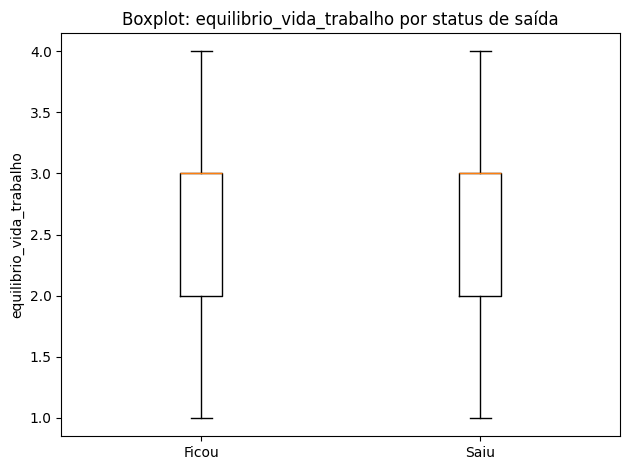

In [25]:
# 5) Salário e satisfação influenciam na saída?
cand = ["salario_mensal", "satisfacao_cargo", "satisfacao_ambiente",
        "satisfacao_relacionamento", "equilibrio_vida_trabalho"]
cand = [c for c in cand if c in df.columns]

if "saiu" in df.columns and cand:
    for col in cand:
        g = df.groupby("saiu")[col].mean()
        print(f"{col} — média por status (False=ficou, True=saiu):")
        print(g)

        plt.figure()
        data0 = df[df["saiu"] == False][col].dropna()
        data1 = df[df["saiu"] == True][col].dropna()
        plt.boxplot([data0, data1], labels=["Ficou","Saiu"])
        plt.title(f"Boxplot: {col} por status de saída")
        plt.ylabel(col)
        plt.tight_layout()
        plt.show()
else:
    print("Coluna 'saiu' ou variáveis de satisfação não disponíveis.")

In [26]:
# 6) Custo estimado da rotatividade 
replacement_cost_pct = 0.5  # Aplicado a taxa de 50% do salário anual

if "saiu" in df.columns and "salario_mensal" in df.columns:
    leavers = df[df["saiu"] == True].copy()
    leavers["salario_anual"] = leavers["salario_mensal"] * 12
    total_cost = (leavers["salario_anual"] * replacement_cost_pct).sum()
    print(f"Custo total estimado (replacement_cost_pct={replacement_cost_pct:.0%}): $ {total_cost:,.2f}")
    
    if "departmento" in df.columns:
        dept_cost = (leavers.groupby("departmento")["salario_anual"].sum() * replacement_cost_pct).sort_values(ascending=False)
        print("\nCusto estimado por departamento:")
        display(dept_cost.to_frame("estimated_turnover_cost"))
else:
    print("Colunas necessárias não encontradas para estimativa de custo.")

print(
    '''
Nota: O custo da rotatividade é o salário anual dos desligados multiplicado por uma 
taxa de reposição (30% a 70%, segundo SHRM e Gallup), que representa gastos com 
recrutamento, integração, treinamento e perda de produtividade.
Neste modelo usei 50% como cenário médio, adequado quando não há dados específicos:
- 30%: funções operacionais (menor curva de aprendizado)
- 70%: cargos especializados/liderança (maior investimento)
- 50%: referência intermediária aceita em estudos de mercado
'''
)


Custo total estimado (replacement_cost_pct=50%): $ 6,807,246.00

Nota: O custo da rotatividade é o salário anual dos desligados multiplicado por uma 
taxa de reposição (30% a 70%, segundo SHRM e Gallup), que representa gastos com 
recrutamento, integração, treinamento e perda de produtividade.
Neste modelo usei 50% como cenário médio, adequado quando não há dados específicos:
- 30%: funções operacionais (menor curva de aprendizado)
- 70%: cargos especializados/liderança (maior investimento)
- 50%: referência intermediária aceita em estudos de mercado

